In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from scipy.fftpack import dct, idct
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score ,confusion_matrix ,ConfusionMatrixDisplay
from sklearn.svm import SVC
import time


## Download the reduced MNIST dataset
- The original MNIST dataset has 60,000 training images and 10,000 test images.
- We will Download from kaggle a reduced dataset with 10,000 training images(1000 for each digit) and 2,000 test images (200 for each digit).

In [4]:
import os
from PIL import Image

# Define the path to the training data folder
train_dir = '/home/rero/Nueral-Networks-projects/Assignment2/part1/Reduced MNIST Data/Reduced Training data'
test_dir = '/home/rero/Nueral-Networks-projects/Assignment2/part1/Reduced MNIST Data/Reduced Testing data'

# Initialize lists to store images and labels
images = []
labels = []

# Loop through each subfolder (which are named '0' to '9')
for label in sorted(os.listdir(train_dir)):
    label_dir = os.path.join(train_dir, label)
    if os.path.isdir(label_dir):
        for img_name in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_name)
            with Image.open(img_path) as img:
                img = img.convert('L')  # Convert image to grayscale
                img_array = np.array(img, dtype=np.float32)  # Convert to float for normalization
                img_array /= 255.0  # Normalize pixel values to the range [0, 1]
                images.append(img_array)
                labels.append(int(label))  # Use the folder name as the label

# Convert lists to NumPy arrays for further processing
images = np.array(images)
labels = np.array(labels)


# Initialize lists to store test images and labels
test_images = []
test_labels = []

# Loop through each subfolder in the test directory
for label in sorted(os.listdir(test_dir)):
    label_dir = os.path.join(test_dir, label)
    if os.path.isdir(label_dir):
        for img_name in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_name)
            with Image.open(img_path) as img:
                img = img.convert('L')  # Convert image to grayscale
                img_array = np.array(img, dtype=np.float32)  # Convert to float for normalization
                img_array /= 255.0  # Normalize pixel values to the range [0, 1]
                test_images.append(img_array)
                test_labels.append(int(label))  # Use the folder name as the label

# Convert lists to NumPy arrays for further processing
test_images = np.array(test_images)
test_labels = np.array(test_labels)



# Display basic information about the dataset
print("Number of images loaded:", images.shape[0])
print("Shape of each image:", images.shape[1:])  # e.g., (height, width)
print("Number of labels loaded:", labels.shape[0])


# Display basic information about the test dataset
print("Number of test images loaded:", test_images.shape[0])
print("Shape of each test image:", test_images.shape[1:])  # e.g., (height, width)
print("Number of test labels loaded:", test_labels.shape[0])

/tmp/ipykernel_30023/1647336361.py:20: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  img_array = np.array(img, dtype=np.float32)  # Convert to float for normalization
/tmp/ipykernel_30023/1647336361.py:42: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  img_array = np.array(img, dtype=np.float32)  # Convert to float for normalization


Number of images loaded: 10000
Shape of each image: (28, 28)
Number of labels loaded: 10000
Number of test images loaded: 2000
Shape of each test image: (28, 28)
Number of test labels loaded: 2000


In [5]:

X_train, y_train, X_test, y_test = images,labels,test_images,test_labels#create_reduced_mnist(X, y)


X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
#

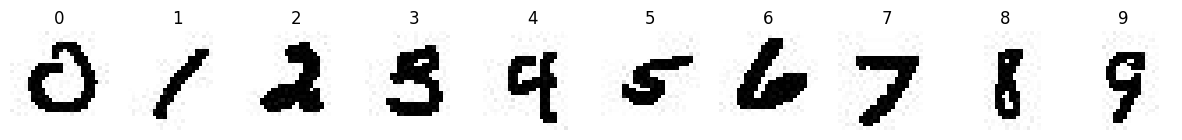

In [6]:
# Plot some images
fig, axes = plt.subplots(1, 10, figsize=(15, 3))
for i in range(10):
    ax = axes[i]
    # Find the first image of each class
    idx = np.where(y_train == i)[0][0]
    ax.imshow(X_train[idx].reshape(28, 28), cmap='binary')
    ax.axis('off')
    ax.set_title(i)
plt.show()



## DCT
- The Discrete Cosine Transform (DCT) is a technique used in image compression.
- The DCT is similar to the Discrete Fourier Transform (DFT) but uses only real numbers.
- The DCT is used in JPEG image compression.


In [7]:
def extract_dct_features(X,n_components=225):
    sqrt_img = int(np.sqrt(X.shape[1]))
    sqrt_n = int(np.sqrt(n_components))
    dct_features = []
    for img in X:
        # Reshape image to 2D from 1D-array
        #img = img.reshape(sqrt_img,sqrt_img)

        # Apply 2D DCT
        dct_img = dct(dct(img,axis=0, norm='ortho'),axis=1, norm='ortho')

        # Extract top-left sqrt_n x sqrt_n coefficients
        dct_features.append(dct_img[:sqrt_n,:sqrt_n].flatten())

    return np.array(dct_features)


# Function to reconstruct image from DCT features
def reconstruct_from_dct(dct_features, original_shape=(28, 28), dct_size=15):
    dct_full = np.zeros(original_shape)
    dct_full[:dct_size, :dct_size] = dct_features.reshape(dct_size, dct_size)
    reconstructed = idct(idct(dct_full, axis=0, norm='ortho'), axis=1, norm='ortho')
    return reconstructed

In [8]:
# Extract DCT features
n_components = 225
X_train_dct = extract_dct_features(X_train, n_components)
X_test_dct = extract_dct_features(X_test, n_components)

# Reconstruct images
X_train_reconstructed_DCT = np.array([reconstruct_from_dct(x) for x in X_train_dct])
X_test_reconstructed_DCT = np.array([reconstruct_from_dct(x) for x in X_test_dct])





In [9]:

def visualize_digits(original=None, dct_reconstructed=None, pca_reconstructed=None, y=None):
    """
    Visualize one example per digit (0-9) from the MNIST dataset, showing original,
    DCT-reconstructed, and PCA-reconstructed images as separate rows.

    Parameters:
    - original: ndarray of shape (n_samples, 784) or (n_samples, 28, 28), or None
    - dct_reconstructed: ndarray of same shape as original, or None
    - pca_reconstructed: ndarray of same shape as original, or None
    - y: ndarray of shape (n_samples,), labels for each sample

    Raises:
    - ValueError: If y is None or if image shapes are invalid
    """
    # Ensure labels are provided
    if y is None:
        raise ValueError("Labels y must be provided.")

    # Collect image types to display
    image_types = []
    if original is not None:
        image_types.append(('Original', original))
    if dct_reconstructed is not None:
        image_types.append(('DCT Reconstructed', dct_reconstructed))
    if pca_reconstructed is not None:
        image_types.append(('PCA Reconstructed', pca_reconstructed))

    # If no images are provided, exit
    if not image_types:
        print("No images to display.")
        return

    # Select the first index for each digit (0-9)
    selected_indices = [np.where(y == digit)[0][0] for digit in range(10)]

    # Create figure with rows equal to number of image types and 10 columns
    fig, axes = plt.subplots(len(image_types), 10, figsize=(30, len(image_types) * 3))

    # Ensure axes is 2D even if there's only one row
    if len(image_types) == 1:
        axes = np.expand_dims(axes, axis=0)

    # Plot images for each image type and digit
    for type_index, (type_name, img_array) in enumerate(image_types):
        for digit in range(10):
            ax = axes[type_index, digit]
            idx = selected_indices[digit]
            img = img_array[idx]

            # Reshape image if necessary
            if img.ndim == 1 and img.size == 784:
                img = img.reshape(28, 28)
            elif img.shape != (28, 28):
                raise ValueError(f"Image for {type_name} must be of shape (28, 28) or (784,)")

            # Display the image
            ax.imshow(img, cmap='gray')

            # Add digit labels above the first row
            if type_index == 0:
                ax.set_title(f'Digit {digit}')

            # Remove axes
            ax.axis('off')

    # Add image type labels to the left of each row
    for type_index, (type_name, _) in enumerate(image_types):
        ax = axes[type_index, 0]
        ax.text(-0.1, 0.5, type_name, transform=ax.transAxes, fontsize=12,
                va='center', ha='right')

    # Adjust layout to make space for row labels
    fig.subplots_adjust(left=0.15)
    plt.show()

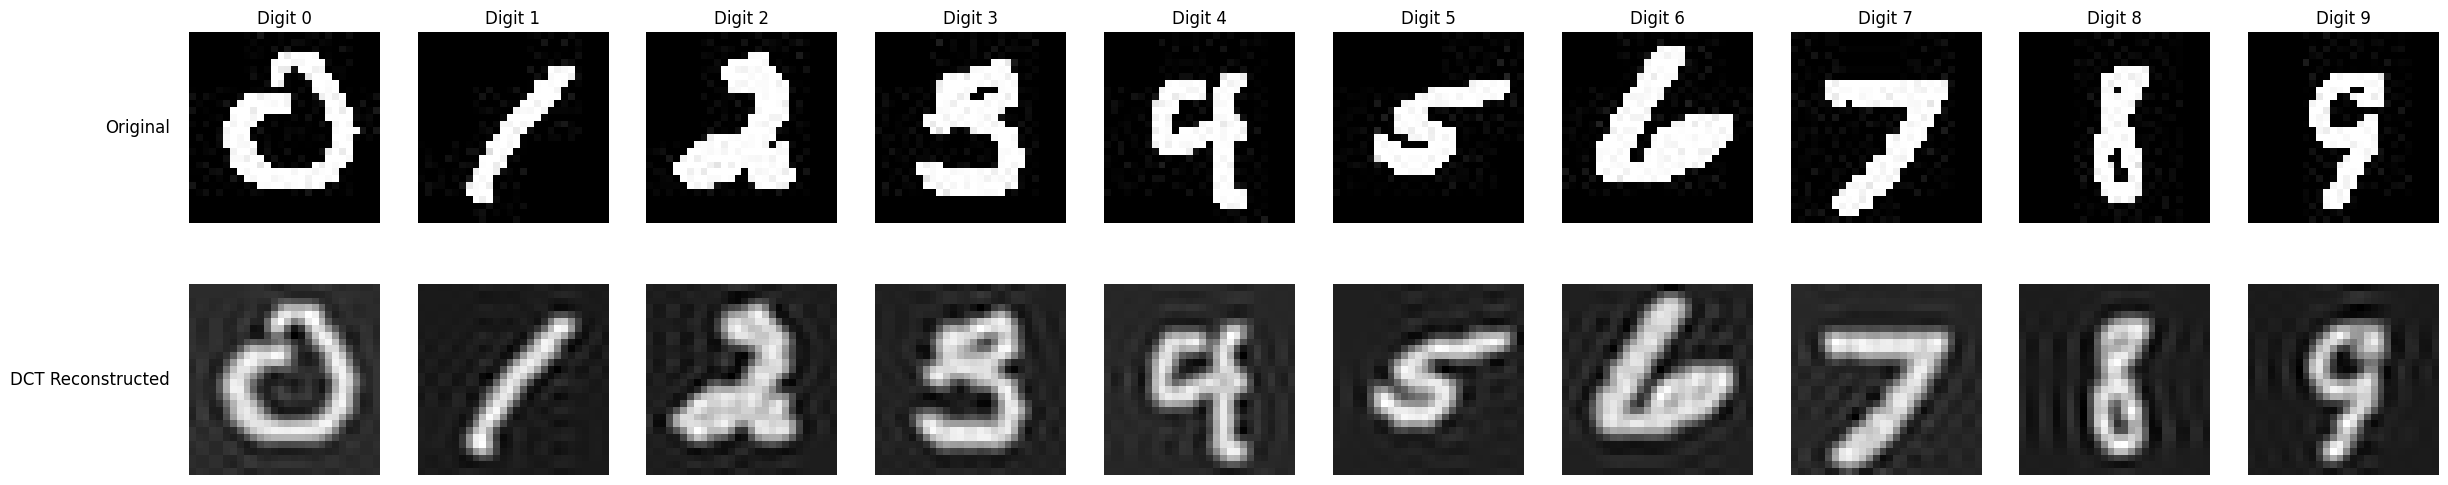

In [10]:
visualize_digits(original=X_train, dct_reconstructed=X_train_reconstructed_DCT, pca_reconstructed=None, y=y_train)

## PCA
- Principal Component Analysis (PCA) is a technique used for dimensionality reduction.
- PCA finds the directions (principal components) in which the data has the most variance.
- The principal components are orthogonal to each other.
- The principal components are sorted by the amount of variance they explain.



Original number of dimensions: 784, PCA number of dimensions: 262


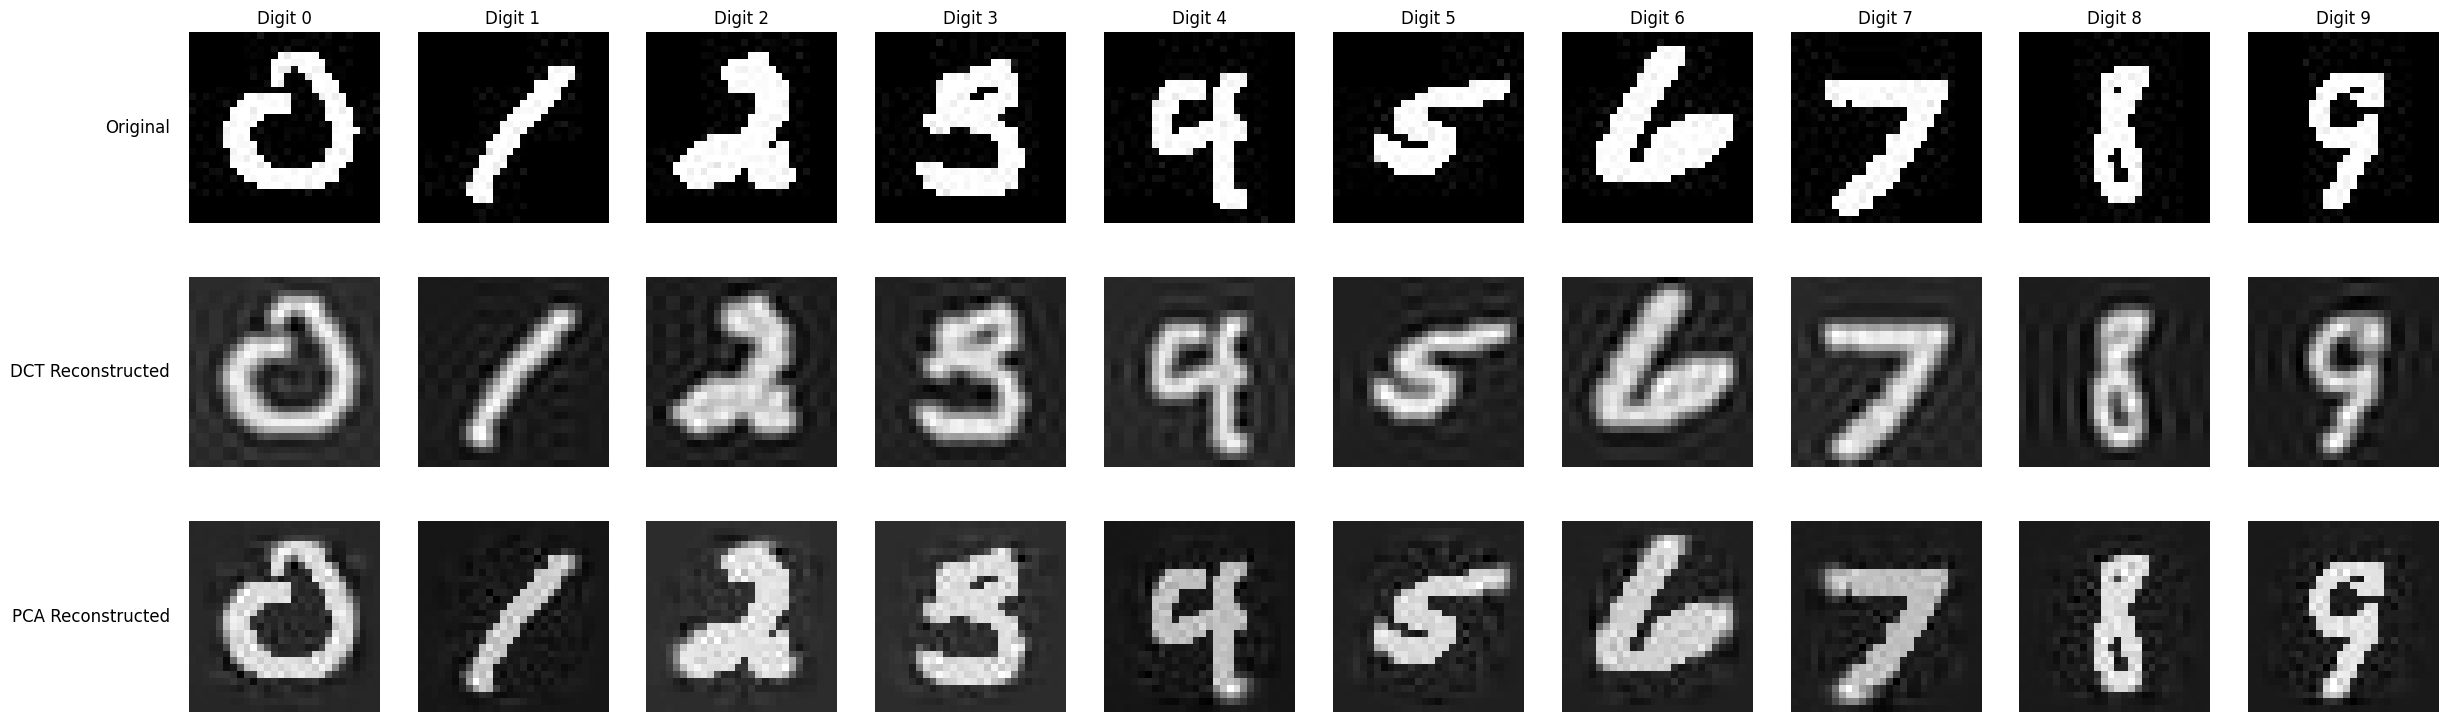

In [11]:

# Reshape data to 2D
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Apply PCA to Original Data
variance = 0.95
pca = PCA(n_components=variance)
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

print(f"Original number of dimensions: {X_train_flat.shape[1]}, PCA number of dimensions: {X_train_pca.shape[1]}")

# Reconstruct images
X_train_reconstructed_PCA = pca.inverse_transform(X_train_pca).reshape(X_train.shape)
X_test_reconstructed_PCA = pca.inverse_transform(X_test_pca).reshape(X_test.shape)

visualize_digits(original=X_train, dct_reconstructed=X_train_reconstructed_DCT, pca_reconstructed=X_train_reconstructed_PCA, y=y_train)



# Autoencoder for Assignment 2

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers


def extract_autoencoder_features(train_data, test_data, num_components=64, epochs=10, batch_size=64):
    """Train an autoencoder and extract features from the bottleneck layer."""
    input_dim = train_data.shape[1]  # 784, assuming MNIST-like data
    
    # Define encoder architecture
    input_layer = Input(shape=(input_dim,))
    encoded1 = Dense(512, activation='relu')(input_layer)  # 784 -> 512
    encoded2 = Dense(256, activation='relu')(encoded1)     # 512 -> 256
    encoded3 = Dense(128, activation='relu')(encoded2)     # 256 -> 128
    bottleneck = Dense(num_components, activation='relu')(encoded3)  # 128 -> num_components (default 64)
    
    # Define decoder architecture
    decoded1 = Dense(128, activation='relu')(bottleneck)   # num_components -> 128
    decoded2 = Dense(256, activation='relu')(decoded1)     # 128 -> 256
    decoded3 = Dense(512, activation='relu')(decoded2)     # 256 -> 512
    output_layer = Dense(input_dim, activation='sigmoid')(decoded3)  # 512 -> 784
    
    # Build and compile autoencoder
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    
    # Build encoder for feature extraction
    encoder = Model(inputs=input_layer, outputs=bottleneck)
    
    # Train the autoencoder
    autoencoder.fit(train_data, train_data,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(test_data, test_data),
                    verbose=1)
    
    # Extract features
    train_ae_features = encoder.predict(train_data)
    test_ae_features = encoder.predict(test_data)
    
    return train_ae_features, test_ae_features, encoder, autoencoder



# Extract autoencoder features
n_components = 225
X_train_auto_encoder, X_test_auto_encoder, encoder, autoencoder = extract_autoencoder_features(X_train_flat, X_test_flat, n_components,epochs=10)

2025-03-26 20:50:32.142690: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-26 20:50:32.219311: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-26 20:50:32.278082: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743015032.303423   30023 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743015032.307771   30023 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743015032.320741   30023 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Epoch 1/10


E0000 00:00:1743015035.381725   30023 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1743015035.382450   30023 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-03-26 20:50:35.498636: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.
2025-03-26 20:50:35.530204: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.1103 - val_loss: 0.0528
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0483 - val_loss: 0.0421
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0396 - val_loss: 0.0344
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0334 - val_loss: 0.0312
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0294 - val_loss: 0.0291
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0270 - val_loss: 0.0274
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0252 - val_loss: 0.0262
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0238 - val_loss: 0.0253
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0229 - val_loss: 0.0239
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0216 - val_loss: 0.0242
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


## Training a classifier
### a-First We will try to train `k-means with [1,4,16,32] clusters` for each class

In [13]:

def kmeans_per_class(X_train, y_train, X_test, y_test, n_clusters_list):
    results = []
    best_model = None
    best_accuracy = -1
    best_n_clusters = None

    for n_clusters in n_clusters_list:
        print(f"\nTraining K-means with {n_clusters} clusters per class...")

        # Start timing training
        train_start_time = time.time()

        # Train K-means for each class
        kmeans_models = {}
        for digit in range(10):
            digit_indices = np.where(y_train == digit)[0]
            X_digit = X_train[digit_indices]
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            kmeans.fit(X_digit)
            kmeans_models[digit] = kmeans

        train_time = time.time() - train_start_time

        # Start timing inference
        inference_start_time = time.time()

        # Predict by finding the closest centroid across all classes
        y_pred = []
        for test_sample in X_test:
            min_dist = float('inf')
            predicted_digit = 0
            for digit in range(10):
                kmeans = kmeans_models[digit]
                distances = np.linalg.norm(test_sample - kmeans.cluster_centers_, axis=1)
                closest_dist = distances.min()
                if closest_dist < min_dist:
                    min_dist = closest_dist
                    predicted_digit = digit
            y_pred.append(predicted_digit)

        inference_time = time.time() - inference_start_time

        # Compute accuracy
        accuracy = accuracy_score(y_test, y_pred)

        results.append({
            'n_clusters': n_clusters,
            'accuracy': accuracy,
            'training_time': train_time,
            'inference_time': inference_time,
            'models': kmeans_models
        })

        # Update best model if current accuracy is higher
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_n_clusters = n_clusters
            best_model = kmeans_models  # Store the dictionary of K-means models for the best configuration

        print(f"n_clusters={n_clusters}: Accuracy={accuracy:.4f}, Training Time={train_time:.2f}s, Inference Time={inference_time:.2f}s")

    return {
        'best_model': best_model,
        'best_n_clusters': best_n_clusters,
        'best_accuracy': best_accuracy,
        'results': results
    }

n_clusters_list = [1, 4, 16, 32]
kmeans_dct_result = kmeans_per_class(X_train_dct, y_train, X_test_dct, y_test, n_clusters_list)
kmeans_pca_result = kmeans_per_class(X_train_pca, y_train, X_test_pca, y_test, n_clusters_list)
kmeans_ae_result = kmeans_per_class(X_train_auto_encoder, y_train, X_test_auto_encoder, y_test, n_clusters_list)
# Access the best K-means model for DCT
best_kmeans_dct = kmeans_dct_result['best_model']
best_kmeans_dct_n_clusters = kmeans_dct_result['best_n_clusters']
best_kmeans_dct_accuracy = kmeans_dct_result['best_accuracy']
print(f"\nBest K-means (DCT): {best_kmeans_dct_n_clusters} clusters, Accuracy={best_kmeans_dct_accuracy:.4f}")

# Access the best K-means model for PCA
best_kmeans_pca = kmeans_pca_result['best_model']
best_kmeans_pca_n_clusters = kmeans_pca_result['best_n_clusters']
best_kmeans_pca_accuracy = kmeans_pca_result['best_accuracy']
print(f"Best K-means (PCA): {best_kmeans_pca_n_clusters} clusters, Accuracy={best_kmeans_pca_accuracy:.4f}")


# Access the best K-means model for AE
best_kmeans_ae = kmeans_ae_result['best_model']
best_kmeans_ae_n_clusters = kmeans_ae_result['best_n_clusters']
best_kmeans_ae_accuracy = kmeans_ae_result['best_accuracy']
print(f"Best K-means (AE): {best_kmeans_ae_n_clusters} clusters, Accuracy={best_kmeans_ae_accuracy:.4f}")



Training K-means with 1 clusters per class...
n_clusters=1: Accuracy=0.8685, Training Time=0.08s, Inference Time=0.14s

Training K-means with 4 clusters per class...
n_clusters=4: Accuracy=0.9190, Training Time=0.07s, Inference Time=0.16s

Training K-means with 16 clusters per class...
n_clusters=16: Accuracy=0.9465, Training Time=0.16s, Inference Time=0.21s

Training K-means with 32 clusters per class...
n_clusters=32: Accuracy=0.9565, Training Time=0.27s, Inference Time=0.25s

Training K-means with 1 clusters per class...
n_clusters=1: Accuracy=0.8680, Training Time=0.03s, Inference Time=0.16s

Training K-means with 4 clusters per class...
n_clusters=4: Accuracy=0.9205, Training Time=0.09s, Inference Time=0.17s

Training K-means with 16 clusters per class...
n_clusters=16: Accuracy=0.9540, Training Time=0.17s, Inference Time=0.22s

Training K-means with 32 clusters per class...
n_clusters=32: Accuracy=0.9605, Training Time=0.33s, Inference Time=0.28s

Training K-means with 1 cluster

In [14]:
print(best_kmeans_dct)

{0: KMeans(n_clusters=32, random_state=42), 1: KMeans(n_clusters=32, random_state=42), 2: KMeans(n_clusters=32, random_state=42), 3: KMeans(n_clusters=32, random_state=42), 4: KMeans(n_clusters=32, random_state=42), 5: KMeans(n_clusters=32, random_state=42), 6: KMeans(n_clusters=32, random_state=42), 7: KMeans(n_clusters=32, random_state=42), 8: KMeans(n_clusters=32, random_state=42), 9: KMeans(n_clusters=32, random_state=42)}


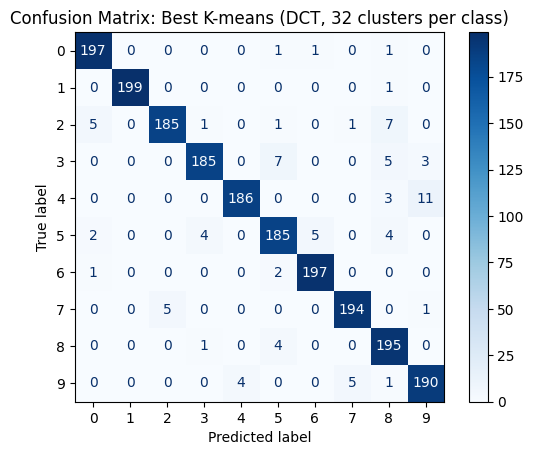

In [15]:


def predict_with_kmeans(kmeans_models, X_test):
    y_pred = []
    for test_sample in X_test:
        min_dist = float('inf')
        predicted_digit = 0
        for digit in range(10):
            kmeans = kmeans_models[digit]
            distances = np.linalg.norm(test_sample - kmeans.cluster_centers_, axis=1)
            closest_dist = distances.min()
            if closest_dist < min_dist:
                min_dist = closest_dist
                predicted_digit = digit
        y_pred.append(predicted_digit)
    return np.array(y_pred)

# Predict using the best K-means model on DCT features
y_pred_kmeans_dct = predict_with_kmeans(best_kmeans_dct, X_test_dct)

# Generate confusion matrix
cm_kmeans_dct = confusion_matrix(y_test, y_pred_kmeans_dct)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_kmeans_dct, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: Best K-means (DCT, 32 clusters per class)')
plt.show()

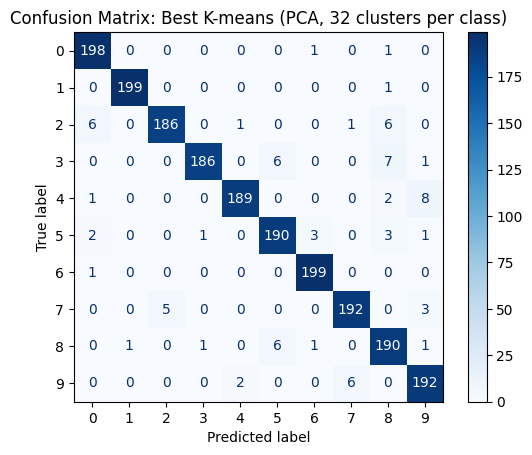

In [16]:
y_pred_kmeans_pca = predict_with_kmeans(best_kmeans_pca, X_test_pca)

# Generate confusion matrix
cm_kmeans_pca = confusion_matrix(y_test, y_pred_kmeans_pca)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_kmeans_pca, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: Best K-means (PCA, 32 clusters per class)')
plt.show()

## SVM


In [17]:

def train_svm(X_train, y_train, X_test, y_test):
    results = []
    best_model = None
    best_accuracy = -1
    best_kernel = None

    # List of SVM configurations with different kernels
    svm_configs = [
        ('Linear', SVC(kernel='linear', random_state=42)),
        ('RBF', SVC(kernel='rbf', random_state=42))
    ]

    for kernel_name, svm in svm_configs:
        print(f"\nTraining SVM with {kernel_name} kernel...")

        # Train the SVM
        train_start_time = time.time()
        svm.fit(X_train, y_train)
        train_time = time.time() - train_start_time

        # Predict on test set
        inference_start_time = time.time()
        y_pred = svm.predict(X_test)
        inference_time = time.time() - inference_start_time

        # Compute accuracy
        accuracy = accuracy_score(y_test, y_pred)

        results.append({
            'kernel': kernel_name,
            'accuracy': accuracy,
            'training_time': train_time,
            'inference_time': inference_time,
            'model': svm
        })

        # Update best model if current accuracy is higher
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_kernel = kernel_name
            best_model = svm

        print(f"SVM ({kernel_name} Kernel): Accuracy={accuracy:.4f}, Training Time={train_time:.2f}s, Inference Time={inference_time:.2f}s")

    return {
        'best_model': best_model,
        'best_kernel': best_kernel,
        'best_accuracy': best_accuracy,
        'results': results
    }

# Example usage
svm_dct_result = train_svm(X_train_dct, y_train, X_test_dct, y_test)
svm_pca_result = train_svm(X_train_pca, y_train, X_test_pca, y_test)
svm_ae_result = train_svm(X_train_auto_encoder, y_train, X_test_auto_encoder, y_test)
# Access the best SVM model for DCT
best_svm_dct = svm_dct_result['best_model']
best_svm_dct_kernel = svm_dct_result['best_kernel']
best_svm_dct_accuracy = svm_dct_result['best_accuracy']
print(f"\nBest SVM (DCT): {best_svm_dct_kernel} kernel, Accuracy={best_svm_dct_accuracy:.4f}")

# Access the best SVM model for PCA
best_svm_pca = svm_pca_result['best_model']
best_svm_pca_kernel = svm_pca_result['best_kernel']
best_svm_pca_accuracy = svm_pca_result['best_accuracy']
print(f"Best SVM (PCA): {best_svm_pca_kernel} kernel, Accuracy={best_svm_pca_accuracy:.4f}")

# Access the best SVM model for AE
best_svm_ae = svm_ae_result['best_model']
best_svm_ae_kernel = svm_ae_result['best_kernel']
best_svm_ae_accuracy = svm_ae_result['best_accuracy']
print(f"Best SVM (AE): {best_svm_ae_kernel} kernel, Accuracy={best_svm_ae_accuracy:.4f}")


Training SVM with Linear kernel...
SVM (Linear Kernel): Accuracy=0.9440, Training Time=1.08s, Inference Time=0.25s

Training SVM with RBF kernel...
SVM (RBF Kernel): Accuracy=0.9710, Training Time=1.36s, Inference Time=1.16s

Training SVM with Linear kernel...
SVM (Linear Kernel): Accuracy=0.9385, Training Time=1.64s, Inference Time=0.84s

Training SVM with RBF kernel...
SVM (RBF Kernel): Accuracy=0.9765, Training Time=2.90s, Inference Time=1.67s

Training SVM with Linear kernel...
SVM (Linear Kernel): Accuracy=0.9570, Training Time=1.29s, Inference Time=0.14s

Training SVM with RBF kernel...
SVM (RBF Kernel): Accuracy=0.9685, Training Time=0.96s, Inference Time=0.95s

Best SVM (DCT): RBF kernel, Accuracy=0.9710
Best SVM (PCA): RBF kernel, Accuracy=0.9765
Best SVM (AE): RBF kernel, Accuracy=0.9685


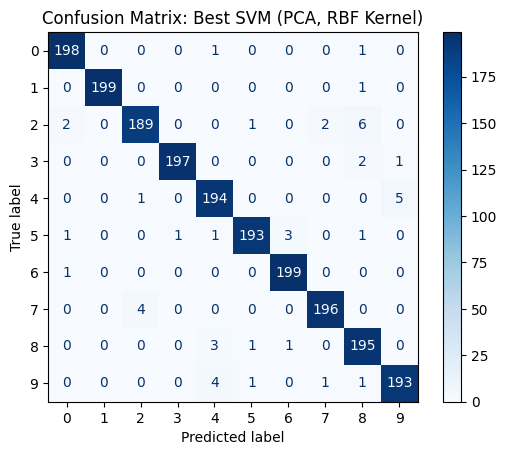

In [18]:
# Confusion matrix for best SVM (PCA)
y_pred_svm_pca = best_svm_pca.predict(X_test_pca)
cm_svm_pca = confusion_matrix(y_test, y_pred_svm_pca)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm_pca, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: Best SVM (PCA, RBF Kernel)')
plt.show()


In [20]:
# Summary Table
print("\nSummary Table:")
print("| Classifier           | Features | Accuracy | Training Time (ms) | Inference Time (ms) | Best Model |")
print("|----------------------|----------|----------|-------------------|---------------------|------------|")

# K-means results
for i, n_clusters in enumerate(n_clusters_list):
    dct_result = kmeans_dct_result['results'][i]
    pca_result = kmeans_pca_result['results'][i]
    ae_result = kmeans_ae_result['results'][i]
    is_best_dct = (n_clusters == kmeans_dct_result['best_n_clusters'])
    is_best_pca = (n_clusters == kmeans_pca_result['best_n_clusters'])
    is_best_ae = (n_clusters == kmeans_ae_result['best_n_clusters'])
    best_label = ''
    if is_best_dct:
        best_label += 'DCT '
    if is_best_pca:
        best_label += 'PCA '
    if is_best_ae:
        best_label += 'AE '
    best_label = best_label.strip() or '-'
    print(f"| K-means ({n_clusters:2d} clusters) | DCT      | {dct_result['accuracy']*100:.4f} | {dct_result['training_time']:6.2f} | {dct_result['inference_time']:6.2f} | {best_label:10s} |")
    print(f"| K-means ({n_clusters:2d} clusters) | PCA      | {pca_result['accuracy']*100:.4f} | {pca_result['training_time']:6.2f} | {pca_result['inference_time']:6.2f} | {best_label:10s} |")
    print(f"| K-means ({n_clusters:2d} clusters) | AE       | {ae_result['accuracy']*100:.4f} | {ae_result['training_time']:6.2f} | {ae_result['inference_time']:6.2f} | {best_label:10s} |")

# SVM results
for i, kernel in enumerate(['Linear', 'RBF']):
    dct_result = svm_dct_result['results'][i]
    pca_result = svm_pca_result['results'][i]
    ae_result = svm_ae_result['results'][i]
    is_best_dct = (kernel == svm_dct_result['best_kernel'])
    is_best_pca = (kernel == svm_pca_result['best_kernel'])
    is_best_ae = (kernel == svm_ae_result['best_kernel'])
    best_label = ''
    if is_best_dct:
        best_label += 'DCT '
    if is_best_pca:
        best_label += 'PCA '
    if is_best_ae:
        best_label += 'AE '
    best_label = best_label.strip() or '-'
    print(f"| SVM ({kernel:7s})         | DCT      | {dct_result['accuracy']*100:.4f} | {dct_result['training_time']:6.2f} | {dct_result['inference_time']:6.2f} | {best_label:10s} |")
    print(f"| SVM ({kernel:7s})         | PCA      | {pca_result['accuracy']*100:.4f} | {pca_result['training_time']:6.2f} | {pca_result['inference_time']:6.2f} | {best_label:10s} |")
    print(f"| SVM ({kernel:7s})         | AE       | {ae_result['accuracy']*100:.4f} | {ae_result['training_time']:6.2f} | {ae_result['inference_time']:6.2f} | {best_label:10s} |")


Summary Table:
| Classifier           | Features | Accuracy | Training Time (ms) | Inference Time (ms) | Best Model |
|----------------------|----------|----------|-------------------|---------------------|------------|
| K-means ( 1 clusters) | DCT      | 86.8500 |   0.08 |   0.14 | -          |
| K-means ( 1 clusters) | PCA      | 86.8000 |   0.03 |   0.16 | -          |
| K-means ( 1 clusters) | AE       | 86.4500 |   0.03 |   0.14 | -          |
| K-means ( 4 clusters) | DCT      | 91.9000 |   0.07 |   0.16 | -          |
| K-means ( 4 clusters) | PCA      | 92.0500 |   0.09 |   0.17 | -          |
| K-means ( 4 clusters) | AE       | 92.5000 |   0.07 |   0.17 | -          |
| K-means (16 clusters) | DCT      | 94.6500 |   0.16 |   0.21 | -          |
| K-means (16 clusters) | PCA      | 95.4000 |   0.17 |   0.22 | -          |
| K-means (16 clusters) | AE       | 94.4000 |   0.16 |   0.20 | -          |
| K-means (32 clusters) | DCT      | 95.6500 |   0.27 |   0.25 | DCT PCA AE |